<a href="https://colab.research.google.com/github/RebeccaKessler/Otter_Group_Project/blob/main/Appendix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#importing packages
import numpy as np
import pandas as pd
import os
import re
import plotly.express as px
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")
!pip install stargazer
from stargazer.stargazer import Stargazer
!pip install linearmodels
from linearmodels.panel import PanelOLS
from sklearn.linear_model import LinearRegression

# Appendix 1: Data Cleaning

**Data Collection: Dependent and Independent Variable**

We obtained our datasets of potato yields and surface temperature changes from FAOSTAT. The potato dataset contains yearly values from 1961 until 2022, whereas the temperature datasets contains both yearly and monthly values for the same period.
The potato dataset contains value on potato yields in tons per country as well as hectares of agricultural land harvested on which's basis we calculated a new variable "potato yields per hectares (t/ha).
The changes in surface temperature refer to the change in temperature compared to the average temperature during the baseline period 1951-1980. <br><br>


**Data Cleaning**

In a first step we looked at missing values. Both datasets had missing values. These were mostly small island states or countries that have ceased to exist or broke up and regrouped.
We approached the missing values as follows:
- missing values in countries not contributing significantly to global potato yields -> exclusion from our sample
- missing values in countries contributing signficiantly to global potato yields (former USSR, Yugoslavio, Ethiopia, Beligum-Luxembourg, Czechoslovakia) -> regrouping of the countries that make up the state that ceased to exist. <br><br>

The regrouping was done as follows:
- potato yields: we added up the tons as well as the hectares of the harvested land of each country and then divided the total tons by the total hectare of the regrouped state (e.g. add up the tons and hectares of all the states of former USSR and then divide the total ton by the total hectare to "recreate" USSR)
- change in surface temperature: we calculated the weighted sum uf the temperature change based on the surface area of the respective countries. This approach is based on the methodology employed by FAOSTAT to calculate changes in surface temperature at the country level.

Lastly, we had to rename some countries (e.g. Türkiye to Turkey) to ensure that the same country have the same name in both datasets.<br><br>



**Calculation of Seasonal Temperature and Potato Yield Growth**

To gain a more fine grained understanding of how temperature affects potato yields, we looked at the growing season of potatoes in the northern and southern hemispheres. To build over independent variable, we then took the mean of the temperautres in the repective months for each country rather than the temperature mean over the whole year. For the northern hemisphere this is May - September and for the Southern hemisphere November - March. This will be our independent variable "temperature".

For our dependent variable, we calculated the yearly growth rate of potato yields per hectares to analyze whether or not increasing temperatures are leading to a decrease in the growth of potato yields per hectare. This was done as follows: <br><br>


$$
g = \frac{{Yield_n - \ Yield_{(n-1)}}}{{Yield_{(n-1)}}}*100
$$<br><br>

This variable will be our main dependent variable in our regression.<br><br>



**Control Variables**

Our control variables consist of GDP per capita, fertilizer (g/ha), irrigation (share of total agricultural land), and precipitation (mm/country constant). With the expection of precipitation, we collected all the data via FAOSTAT as well. The monthly precipitation dataset stems from ccpk.
To clean our controls, we followed the same approach as with our main variables. Given that all variables are normalized to the country side, we followed the same procedure than temperature, thus calculating the weighted sum of the states that ceased to exist based on either their surface, population, or total agricultural land.<br><br>


**Calculation of Precipitation Variation**

Similar to our variable "changes in temperature", we are mostly interested in precipiation during the growing season and not over the whole year. We thus again calculated the average precipitation of each country during their potato growing season.

In addition, we calculated precipitation variation. For this, we took the mean precipitation over the years 1970-2020 for each country and then calculated the difference between each year's value and this mean. Precipiation is a more powerful indicator of how precipiation patterns are changing as there are no clear increasing or decreasing trends in many countries but rather more extreme seasonal variations. Anomalies thus allow us to differentiate between seasons that get less vs more rain than the average. This variable 'precipiation variation' will later become our variable of heterogeneity.<br><br>


**Final Sample**

Our final sample size is equal to 97, meaning our sample consists of 97 countries. Irrigation unfortunately drastically reduces this sample size to 66 as the data is not available in some areas of the world. We hence run our baseline model once with and once without irrigation. The main model used for our interpretion, however, will be the one without irrigation.





# Appendix 2: Seasonal Analysis


In [30]:
#importing our datasets
url = "https://raw.githubusercontent.com/RebeccaKessler/Otter_Group_Project/main/Data%20for%20Final%20Project/cross_section_data.csv?token=GHSAT0AAAAAACL4W2FUCWMXAE63TXCYPNNGZMFSSRA"
df_cross = pd.read_csv(url)
url = "https://raw.githubusercontent.com/RebeccaKessler/Otter_Group_Project/main/Data%20for%20Final%20Project/Panel_Analysis_absolute.csv?token=GHSAT0AAAAAACL4W2FVFZNNHC5XUUIIOVREZMFSS7A"
df_panel_absolute = pd.read_csv(url)
url = "https://raw.githubusercontent.com/RebeccaKessler/Otter_Group_Project/main/Data%20for%20Final%20Project/Panel_Analysis_growth.csv?token=GHSAT0AAAAAACL4W2FUS46AN5EQKAK5YQUYZMFSTOA"
df_panel_growth = pd.read_csv(url)
url = "https://raw.githubusercontent.com/RebeccaKessler/Otter_Group_Project/main/Data%20for%20Final%20Project/Panel_Analysis_growth_irrigation.csv?token=GHSAT0AAAAAACL4W2FVSP7ELWWBXGBCKL5IZMFST4A"
df_panel_growth_irrigation = pd.read_csv(url)

In [31]:
# Definition of continents
Africa = ["Algeria",'Angola','Cameroon','Central African Republic','Chad','Democratic Republic of the Congo','Egypt','Eswatini','Ethiopia PDR', 'Kenya','Lesotho','Libya','Madagascar',"Malawi","Mauritania",  'Mauritius',  'Morocco',  'Mozambique',  'Nigeria',  'Senegal', 'South Africa',  'Tunisia', 'Uganda',  'United Republic of Tanzania',  'Zambia','Zimbabwe']
NA = ['Canada','Cuba','Dominica','Dominican Republic','El Salvador','Guatemala','Haiti','Honduras', "Mexico",  'Nicaragua',  'United States of America']
SA = ['Argentina','Bolivia (Plurinational State of)','Brazil','Chile','Colombia','Ecuador', "Paraguay",  'Peru', 'Uruguay', 'Venezuela (Bolivarian Republic of)']
Asia = ["Afghanistan",'Bangladesh','Bhutan','Cyprus',"China","Democratic People's Republic of Korea",'India','Indonesia','Iran (Islamic Republic of)','Iraq','Israel', 'Japan','Jordan',"Lao People's Democratic Republic", 'Lebanon',  'Mongolia',  'Myanmar',  'Nepal',  'Pakistan',  'Philippines',  'Republic of Korea', 'Saudi Arabia',  'Sri Lanka',  'Syrian Arab Republic',  'Thailand',  'Türkiye',  'Viet Nam']
Europe = ["USSR",'Albania','Austria','Belgium-Luxembourg','Bulgaria','Czechoslovakia','Denmark','Faroe Islands','Finland','France','Germany','Greece','Hungary','Iceland','Ireland','Italy', "Malta",  'Netherlands (Kingdom of the)',  'Norway',  'Poland', 'Portugal',  'Romania',  'Spain', 'Sweden',  'Switzerland',  'United Kingdom of Great Britain and Northern Ireland',  'Yugoslav SFR']
Oceania = ['Australia','Fiji','French Polynesia', "New Caledonia", 'New Zealand', 'Papua New Guinea']

In [32]:
# defining outliers
outliers = ['Guatemala', 'Cameroon', "Jordan", "Democratic People's Republic of Korea", 'Nigeria', 'Zimbabwe']
# Guetemala and Cameroon started their potato production much later than the other countries. This leads to a sudden and extreme growth in their potato yields per hectare.
# The Democratic People's Republic of Korea, Nigeria, Jordan, and Zimbabwe show sudden and large drops in their potato yields per hectare due to political conflicts or constrained socio-economic conditions.
# These extreme outliers will be excluded from our analysis.
# However, we reintroduce them in our robustness checks (see Appendix 2.5.2).

## 2.1 Panel Analysis Absolute Values

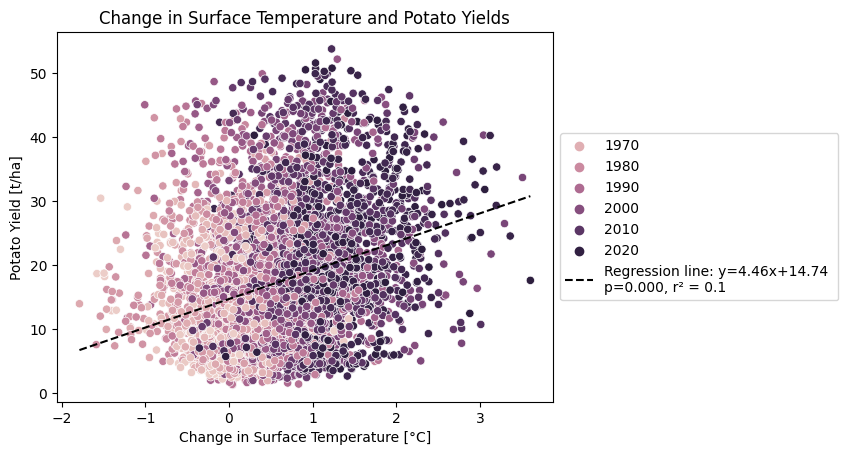

In [33]:
# Linear regression of absolute potato yields (no controls)
df_panel_absolute_no_outliers = df_panel_absolute[~df_panel_absolute['Area'].isin(outliers)]

sns.scatterplot(x='Value_T', y='Value_Y', hue='Year', data=df_panel_absolute)

x = df_panel_absolute_no_outliers.sort_values("Value_T").Value_T
y = df_panel_absolute_no_outliers.sort_values("Value_T").Value_Y

ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T', df_panel_absolute_no_outliers).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]

trendline = slope * x + intercept

line = f'Regression line: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.1f}'

plt.plot(x, trendline, '--', color='k', label=line)

plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Potato Yield [t/ha]')
plt.title('Change in Surface Temperature and Potato Yields')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The coefficient of 4.46 tells us that an increase of 1°C leads to a 4.46 increase in absolute potatoes (t/H). This result is statistically significant (p<0.05). This regression,however, does not inlcude any control variable nor fixed effects.

## 2.2 Panel Analysis Yield Growth



### 2.2.1 Linear Regression

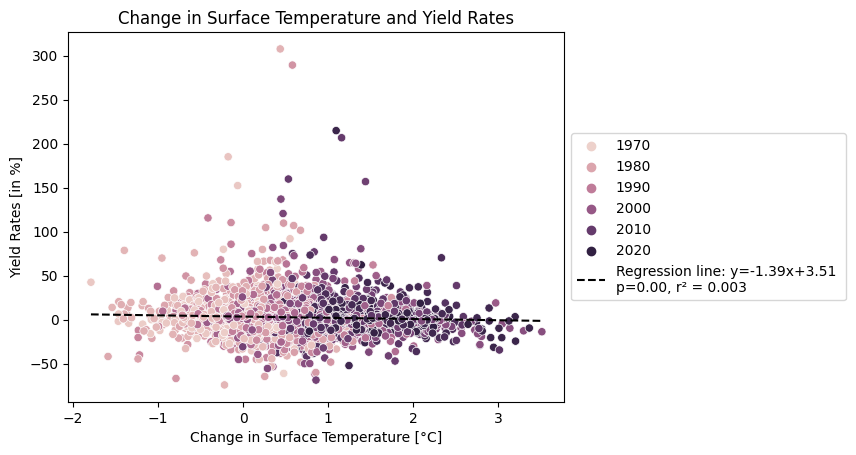

In [34]:
# Linear regression without outliers (no controls)
df_panel_growth_no_outliers = df_panel_growth[~df_panel_growth['Area'].isin(outliers)]

sns.scatterplot(x='Value_T', y='Value_Y', hue='Year', data=df_panel_growth_no_outliers)

x = df_panel_growth.sort_values("Value_T").Value_T
y = df_panel_growth.sort_values("Value_T").Value_Y

ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T', df_panel_growth_no_outliers).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]

trendline = slope * x + intercept

line = f'Regression line: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.2f}, r² = {ols_canned_results.rsquared:.3f}'

plt.plot(x, trendline, '--', color='k', label=line)

plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Yield Rates [in %]')
plt.title('Change in Surface Temperature and Yield Rates')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [35]:
#display regression table
res_1 = sm.OLS.from_formula('Value_Y ~ Value_T', df_panel_growth_no_outliers).fit()

stargazer = Stargazer([res_1])
stargazer

Plotting the growth rate against temperature, we find that a 1°C increase leads to a 1.389 decrease in the annual potato yield rate. This result is statistically significant (p<0.01). However, it does not include any controls nor fixed effects yet.

### 2.2.2 Control Variables

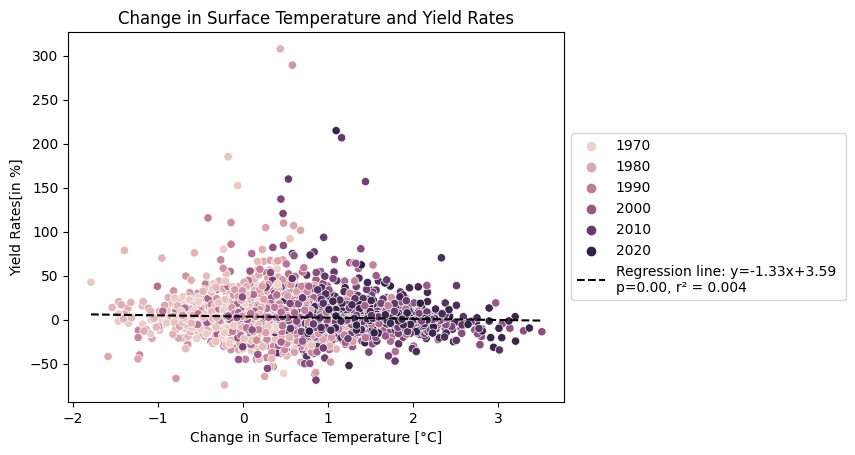

In [36]:
# Linear regression without outliers with controls

sns.scatterplot(x='Value_T', y='Value_Y', hue='Year', data=df_panel_growth_no_outliers)

x = df_panel_growth.sort_values("Value_T").Value_T
y = df_panel_growth.sort_values("Value_T").Value_Y

ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]

trendline = slope * x + intercept

line = f'Regression line: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.2f}, r² = {ols_canned_results.rsquared:.3f}'

plt.plot(x, trendline, '--', color='k', label=line)

plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Yield Rates[in %]')
plt.title('Change in Surface Temperature and Yield Rates')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [37]:
df_panel_growth_irrigation_no_outliers = df_panel_growth_irrigation[~df_panel_growth_irrigation['Area'].isin(outliers)]

In [38]:
#display regression tables
res_1 = sm.OLS.from_formula('Value_Y ~ Value_T', df_panel_growth_no_outliers).fit()
res_2 = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP', df_panel_growth_no_outliers).fit()
res_3 = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert', df_panel_growth_no_outliers).fit()
res_4 = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()
res_5 = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom + Value_Irig', df_panel_growth_irrigation_no_outliers).fit()

stargazer = Stargazer([res_1, res_2, res_3, res_4, res_5])
stargazer

Let's interpret the results (4) when including all controls (except for irrigation which is in column 5)
The result suggests a coefficient of -1.326. This is only a minimal changes compared to the coefficient without controls. The controls do thus not strongly influende our coefficient.
The -0.002 for fertilizer, for example, suggests that a one-unit increase in fertilizer is associated with a decrease of 0.002 units in yield growth which is counter to our intuition. However, the coefficient of fertilizer is not statistically signifciant. We can thus not conclude that the effect of fertilizer on yield rates is not zero.
Looking at the table, only temperature and precipitaton appear statistically significant (p<0.05).
Note, this regresson table does still not include any fixed effects.

### 2.2.3 Fixed Effects

In [39]:
#display regression tables including controls and country-specifc fixed effects
result_fe = PanelOLS.from_formula("Value_Y ~ 1 + Value_T + Value_GDP + Value_Fert + Value_Prec_Anom + EntityEffects",
                            data=df_panel_growth_no_outliers.set_index(["Area", "Year"]))
result_fe = result_fe.fit(cov_type='clustered', cluster_entity=True)
print(result_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                Value_Y   R-squared:                        0.0050
Estimator:                   PanelOLS   R-squared (Between):             -0.4494
No. Observations:                4598   R-squared (Within):               0.0050
Date:                Fri, Dec 22 2023   R-squared (Overall):              0.0012
Time:                        13:35:24   Log-likelihood                -1.968e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.6748
Entities:                          91   P-value                           0.0001
Avg Obs:                       50.527   Distribution:                  F(4,4503)
Min Obs:                       38.000                                           
Max Obs:                       55.000   F-statistic (robust):             6.7085
                            

Introducing our fixed effects and accounting for clustered standard errors changes the picture slightly.

A one-unit increase in temperature is now associated with a decrease of approximatel 1.6157 units in the yield rate. This is slightly more negative than before. The coefficient thereby remains statistically significant (p<0.05).
Interestingly, the coefficient of our control variable fertilizer becomes positive and statistically signifciant at the 0.05%-level. It is thus now in line with our intuition that a one-unit increase in fertilizer use leads to a 0.0062 increase in yield rates.
The coefficient of GDP remains neglectable and statistically insignificant.

The F-test for poolability further suggests that there is no evidence of significant fixed effects in our model. Including or excluding fixed effects does thus not signifciantly change our baseline result.

However, including fixed effects and clustered standard errors, slightly improves the fit of our model as reflected in an increase in the R_squared from 0.004 to 0.005.

### 2.2.4 Discontinuity Regression

In [40]:
#create temperature threshold for discontinuity analysis
#assigning value 1 to countries above the trehsold and 0 to the ones below
threshold = 2
df_panel_growth_no_outliers['dummy_temp'] = df_panel_growth_no_outliers['Value_T'] >= threshold
df_panel_growth_no_outliers["dummy_temp"] = df_panel_growth_no_outliers["dummy_temp"].astype(int)

<Axes: xlabel='Value_T', ylabel='Value_Y'>

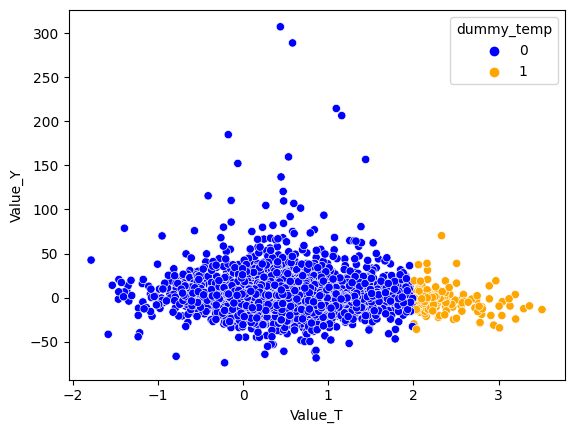

In [41]:
#display scatter
sns.scatterplot(x='Value_T', y='Value_Y', data=df_panel_growth_no_outliers, hue="dummy_temp")

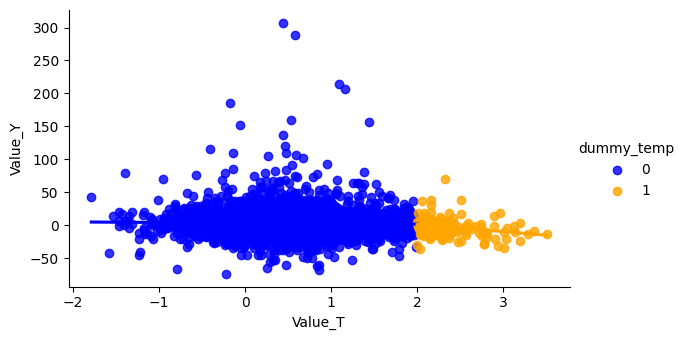

In [42]:
#dispaly simple regression
sns.lmplot(x='Value_T', y='Value_Y', data=df_panel_growth_no_outliers, hue="dummy_temp", height=3.5, aspect=1.7, ci=False)

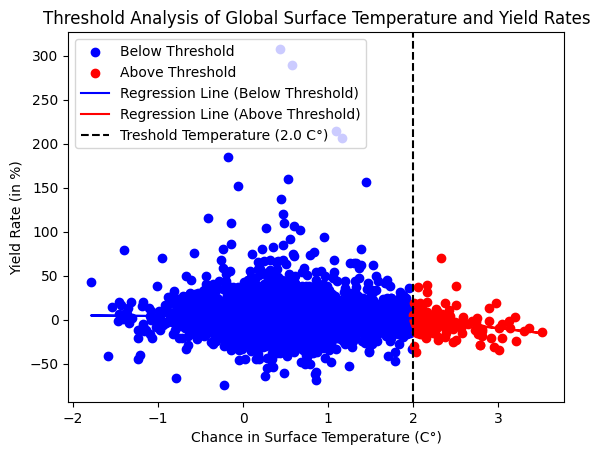

In [43]:
#run regression with threshold
temperature = df_panel_growth_no_outliers['Value_T']
potato_yield = df_panel_growth_no_outliers['Value_Y']

# Create a dummy variable (1 if above threshold, 0 if below threshold)
df_panel_growth_no_outliers['above_threshold'] = (temperature > threshold).astype(int)

# Split the data into two subsets based on the dummy variable
df_below_threshold = df_panel_growth_no_outliers[df_panel_growth_no_outliers['above_threshold'] == 0]
df_above_threshold = df_panel_growth_no_outliers[df_panel_growth_no_outliers['above_threshold'] == 1]

# Fit linear regression models for each subset
model_below_threshold = LinearRegression().fit(df_below_threshold['Value_T'].values.reshape(-1, 1), df_below_threshold['Value_Y'])
model_above_threshold = LinearRegression().fit(df_above_threshold['Value_T'].values.reshape(-1, 1), df_above_threshold['Value_Y'])

# Predict the yields using the fitted models
predictions_below_threshold = model_below_threshold.predict(df_below_threshold['Value_T'].values.reshape(-1, 1))
predictions_above_threshold = model_above_threshold.predict(df_above_threshold['Value_T'].values.reshape(-1, 1))

# Plot the data and regression lines
plt.scatter(df_below_threshold['Value_T'], df_below_threshold['Value_Y'], color='blue', label='Below Threshold')
plt.scatter(df_above_threshold['Value_T'], df_above_threshold['Value_Y'], color='red', label='Above Threshold')

plt.plot(df_below_threshold['Value_T'], predictions_below_threshold, color='blue', label='Regression Line (Below Threshold)')
plt.plot(df_above_threshold['Value_T'], predictions_above_threshold, color='red', label='Regression Line (Above Threshold)')

plt.axvline(x=threshold, color='black', linestyle='--', label='Treshold Temperature (2.0 C°)')

plt.title('Threshold Analysis of Global Surface Temperature and Yield Rates')
plt.xlabel('Chance in Surface Temperature (C°)')
plt.ylabel('Yield Rate (in %)')
plt.legend()
plt.show()

While it might be difficult to read, the regression line after the threshold is a lot steper (more negative) than before the threshold.

In [44]:
#regression output table for interaction term with temperature threshold
res_1 = sm.OLS.from_formula('Value_Y ~ Value_T', df_panel_growth_no_outliers).fit()
res_2 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_temp', df_panel_growth_no_outliers).fit()
res_3 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_temp + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()


stargazer = Stargazer([res_1, res_2, res_3])
stargazer

In [45]:
#display regression tables including temperature dummy and fixed effects
result_fe = PanelOLS.from_formula("Value_Y ~ 1 + Value_T + dummy_temp + Value_T*dummy_temp + Value_GDP + Value_Fert + Value_Prec_Anom + EntityEffects",
                            data=df_panel_growth_no_outliers.set_index(["Area", "Year"]))
result_fe = result_fe.fit(cov_type='clustered', cluster_entity=True)
print(result_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                Value_Y   R-squared:                        0.0073
Estimator:                   PanelOLS   R-squared (Between):             -0.2911
No. Observations:                4598   R-squared (Within):               0.0073
Date:                Fri, Dec 22 2023   R-squared (Overall):              0.0048
Time:                        13:36:13   Log-likelihood                -1.968e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.5403
Entities:                          91   P-value                           0.0000
Avg Obs:                       50.527   Distribution:                  F(6,4501)
Min Obs:                       38.000                                           
Max Obs:                       55.000   F-statistic (robust):             6.4250
                            

The result confirms our expectations. As we move from observations below the threshold to observations above the threshold, the effect of temperature on yield rates is on overage -9.5 units lower. The p-value of 0.002 tells us that this result is statistically signifciant at the 1-% level.

## 2.3 Heterogeneity

In [46]:
#creating a dummy variable "dummy_rain" assigning 1 to all years with a positive precipitation anomalies (meaning more than their average), and 0 for all years with negative anomalies
threshold = 0
df_panel_growth_no_outliers['dummy_rain'] = df_panel_growth_no_outliers['Value_Prec_Anom'] >= threshold
df_panel_growth_no_outliers["dummy_rain"] = df_panel_growth_no_outliers["dummy_rain"].astype(int)

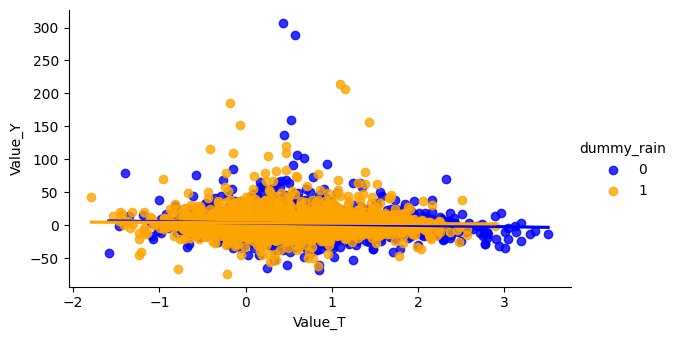

In [47]:
#display the scatter plot with regression line
sns.lmplot(x='Value_T', y='Value_Y', data=df_panel_growth_no_outliers, hue="dummy_rain", height=3.5, aspect=1.7, ci=False)

The slope for observations with positive anomalies is steeper than the one with negative anomalies, thus confirming our expectation.

In [48]:
#regression output table for interaction term with dummy_rain
res_1 = sm.OLS.from_formula('Value_Y ~ Value_T', df_panel_growth_no_outliers).fit()
res_2 = sm.OLS.from_formula('Value_Y ~ Value_T + dummy_rain', df_panel_growth_no_outliers).fit()
res_3 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_rain', df_panel_growth_no_outliers).fit()
res_4 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_rain + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()
#check interaction term with Value_Prec_Anom instead of the dummy
res_5 = sm.OLS.from_formula('Value_Y ~ Value_T*Value_Prec_Anom + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()

stargazer = Stargazer([res_1, res_2, res_3, res_4,res_5])
stargazer

This regression output table suggest that if we move from countries with negative rainfall anomalities to positive ones, the impact of temperature on yield rates becomes 1.445 units less negative. This finding is statistically significant at the 10-% level.Plotting the units instead of the dummy decreases the interaction term, however the direction remains the same, i.e. in countries with more precipiation, the effect of temperature on yield rates is less negative.

In [49]:
#display regression tables including precipitation dummy and fixed effects
result_fe = PanelOLS.from_formula("Value_Y ~ 1 + Value_T + dummy_rain + Value_T*dummy_rain + Value_GDP + Value_Fert + Value_Prec_Anom + EntityEffects",
                            data=df_panel_growth_no_outliers.set_index(["Area", "Year"]))
result_fe = result_fe.fit(cov_type='clustered', cluster_entity=True)
print(result_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                Value_Y   R-squared:                        0.0060
Estimator:                   PanelOLS   R-squared (Between):             -0.4775
No. Observations:                4598   R-squared (Within):               0.0060
Date:                Fri, Dec 22 2023   R-squared (Overall):              0.0019
Time:                        13:36:49   Log-likelihood                -1.968e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.5084
Entities:                          91   P-value                           0.0001
Avg Obs:                       50.527   Distribution:                  F(6,4501)
Min Obs:                       38.000                                           
Max Obs:                       55.000   F-statistic (robust):             5.1482
                            

While the coefficient slightly change, the trend remains the same. In countries with positive precipiation anomalies, the effect of temperature on yield rates is 1.5912 less negative (p<0.05).

## 2.4 Causality

For our DiD we chose to compare Italy and Greece due to their similar climates, levels of crop yields, and cultures.

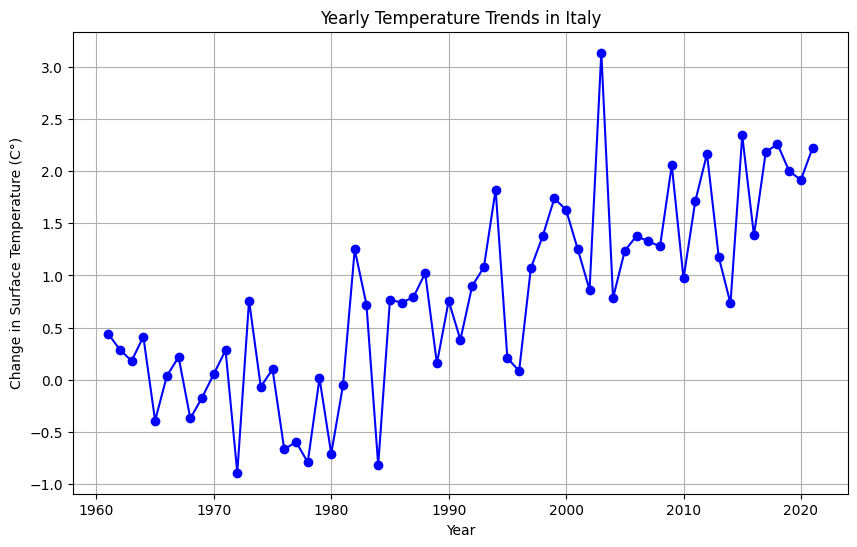

In [50]:
#plotting the temperature of Italy and Greece to identify a temperature shock
italy_data = df_panel_absolute[df_panel_absolute['Area'] == 'Italy']

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(italy_data['Year'], italy_data['Value_T'], marker='o', linestyle='-', color='b')
plt.title('Yearly Temperature Trends in Italy')
plt.xlabel('Year')
plt.ylabel('Change in Surface Temperature (C°)')
plt.grid(True)
plt.show()

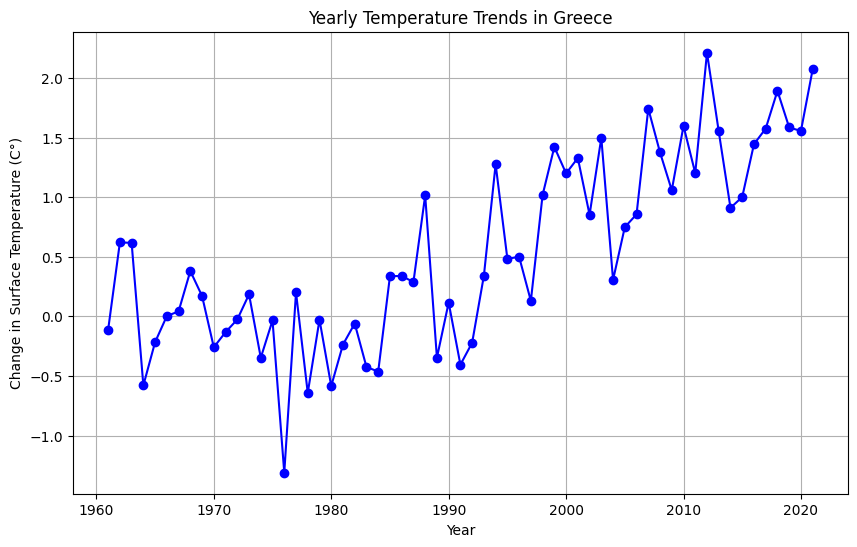

In [51]:
greece_data = df_panel_absolute[df_panel_absolute['Area'] == 'Greece']

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(greece_data['Year'], greece_data['Value_T'], marker='o', linestyle='-', color='b')
plt.title('Yearly Temperature Trends in Greece')
plt.xlabel('Year')
plt.ylabel('Change in Surface Temperature (C°)')
plt.grid(True)
plt.show()

 We identified a temperature shock in the year 2003 in Italy which did not affect Greece.
 We will hence conduct a DiD to identify whether or not this shock in 2003 led to a significant difference between the growth rate of potatos in Italy and Greece.

In [52]:
#running the difference in difference analysis

# Select the control group country
control_country = 'Greece'
# Create the treatment indicator: 1 for Italy, 0 for the control country
df_panel_growth['treatment'] = np.where(df_panel_growth['Area'] == 'Italy', 1,
                           np.where(df_panel_growth['Area'] == control_country, 0, np.nan))

# Drop all other countries from the analysis
df_did = df_panel_growth.dropna(subset=['treatment'])
df_did['Year'] = pd.to_numeric(df_did['Year'])
# Create the time period indicator: 1 for 2003, 0 for before and after 2003
df_did['treatment_year'] = np.where(df_did['Year'] == 2003, 1, 0)
# Create the interaction term
df_did['treatment_effect'] = df_did['treatment'] * df_did['treatment_year']
# OLS regression with interaction term
did_model = sm.OLS.from_formula('Value_Y ~treatment + treatment_year + treatment_effect', df_did).fit()


# Print the summary of the model
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Value_Y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.132
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.101
Time:                        13:37:05   Log-Likelihood:                -306.16
No. Observations:                 102   AIC:                             620.3
Df Residuals:                      98   BIC:                             630.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7016      0.702  

The coefficient of the treatment effect is negative (-16.5922) and statistically significant at the p-level 0.05. We can thus reject the H0 that the difference in the average yield rates between Italy and Greece during the shock compared to the other years is zero.

In [53]:
#This is often checked by ensuring that the interaction term between the treatment group and the time period (year) is not significant in the pre-shock period and, in our case, also the post-shocks period since the shock only happens in one year.
#This allows to see whether or not  the rate of change over time in the outcome variable is also significantly different between the two groups before and after the shock.

# Statistical Check for Parallel Trends
# before 2003 (Pre-shock period 1998-2002)
df_pre_2003 = df_did[df_did['Year'] < 2003]
df_pre_2003 = df_did[df_did['Year'] > 1998]

# Adding an interaction term between treatment and year
df_pre_2003['treatment_x_year'] = df_pre_2003['treatment'] * df_pre_2003['Year']

# Running the regression
parallel_trends_model = sm.OLS.from_formula('Value_Y ~ Year + treatment + treatment_x_year', data=df_pre_2003).fit()

# Output the summary of the model
print(parallel_trends_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Value_Y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9863
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.409
Time:                        13:37:16   Log-Likelihood:                -133.43
No. Observations:                  44   AIC:                             274.9
Df Residuals:                      40   BIC:                             282.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -518.7958    355.566  

We cannot reject H0 (H0: the rate of change in potato yields is signficianttly different between Italy and Greece) at the p-level 0.05 for the pre-shock period.

In [ ]:
# Statistical Check for Parallel Trends
# post 2003 (Post-shock period 2004-2008)

df_post_2003 = df_did[df_did['Year'] > 2003]
df_post_2003 = df_did[df_did['Year'] < 2009]

# Adding an interaction term between treatment and year
df_post_2003['treatment_x_year'] = df_post_2003['treatment'] * df_post_2003['Year']

# Running the regression
parallel_trends_model = sm.OLS.from_formula('Value_Y ~ Year + + treatment + treatment_x_year', data=df_post_2003).fit()

# Output the summary of the model
print(parallel_trends_model.summary())

We can again not reject H0 (H0: the rate of change in potato yields is signficiantly different between Italy and Greece) at the p-level 0.05 for the post-shock period. The combination of these results provide evidence that the shock in 2003 indeed had a sgnificant impact, or at least there there is not significant evidence to say that it did not have an impact, on yield rates in Italy. The negative coefficient obtained in the DiD thereby suggests a drastic decrease in yield rates associated with the temeprature shock

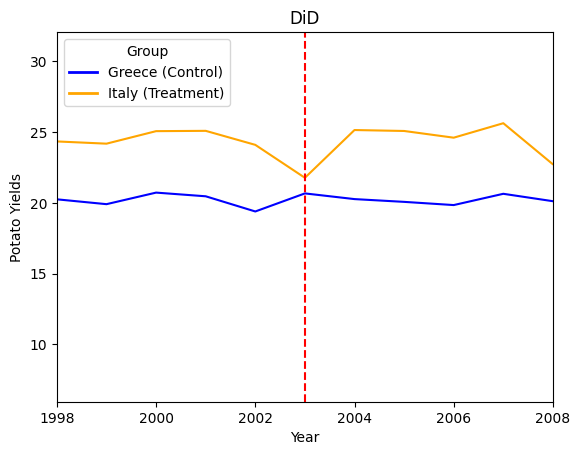

In [54]:
#let's visualize this

control_country = 'Greece'
df_panel_absolute['treatment'] = np.where(df_panel_absolute['Area'] == 'Italy', 1,
                           np.where(df_panel_absolute['Area'] == control_country, 0, np.nan))

df_did = df_panel_absolute.dropna(subset=['treatment'])
df_did['Year'] = pd.to_numeric(df_did['Year'])

palette = {0.0: 'blue', 1.0: 'orange'}

# Set the palette for both lineplot and legend
sns.set_palette(palette.values())


sns.lineplot(x='Year', y='Value_Y', hue='treatment', data=df_did, estimator=np.mean, palette=palette)
plt.title('DiD')
plt.ylabel('Potato Yields')
plt.xlabel('Year')
plt.axvline(x=2003, color='red', linestyle='--', label='Temperature shock in 2003')

# adjust titles in the legend
legend_titles = ['Greece (Control)', 'Italy (Treatment)']
treatment_values = df_did['treatment'].unique()
legend_handles = [plt.Line2D([0], [0], color=palette[label], lw=2) for label in treatment_values]

plt.legend(title='Group', loc='upper left', labels=legend_titles, handles=legend_handles)
plt.xlim(1998, 2008)
plt.show()

## 2.5 Robustness Checks

### 2.5.1 Contintent Analysis

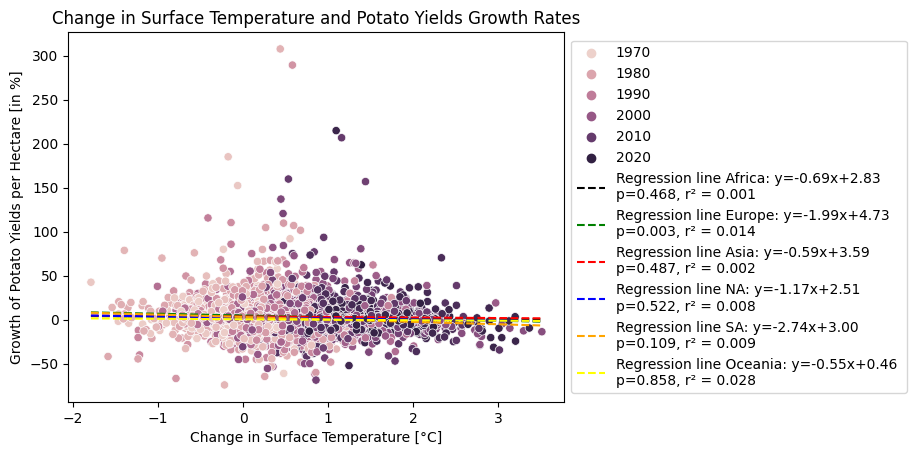

In [55]:
# Linear regression without outliers per continent
df_panel_growth_no_outliers_Africa = df_panel_growth_no_outliers.loc[df_panel_growth_no_outliers.Area.isin(Africa),:]
df_panel_growth_no_outliers_Europe = df_panel_growth_no_outliers.loc[df_panel_growth_no_outliers.Area.isin(Europe),:]
df_panel_growth_no_outliers_Asia = df_panel_growth_no_outliers.loc[df_panel_growth_no_outliers.Area.isin(Asia),:]
df_panel_growth_no_outliers_NA = df_panel_growth_no_outliers.loc[df_panel_growth_no_outliers.Area.isin(NA),:]
df_panel_growth_no_outliers_SA = df_panel_growth_no_outliers.loc[df_panel_growth_no_outliers.Area.isin(SA),:]
df_panel_growth_no_outliers_Oceania = df_panel_growth_no_outliers.loc[df_panel_growth_no_outliers.Area.isin(Oceania),:]

sns.scatterplot(x='Value_T', y='Value_Y', hue='Year', data=df_panel_growth_no_outliers)

x = df_panel_growth.sort_values("Value_T").Value_T
y = df_panel_growth.sort_values("Value_T").Value_Y

#Africa
ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers_Africa).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]
trendline = slope * x + intercept
line = f'Regression line Africa: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.3f}'
plt.plot(x, trendline, '--', color='k', label=line)

#Europe
ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers_Europe).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]
trendline = slope * x + intercept
line = f'Regression line Europe: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.3f}'
plt.plot(x, trendline, '--', color='green', label=line)

#Asia
ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers_Asia).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]
trendline = slope * x + intercept
line = f'Regression line Asia: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.3f}'
plt.plot(x, trendline, '--', color='red', label=line)

#NA
ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers_NA).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]
trendline = slope * x + intercept
line = f'Regression line NA: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.3f}'
plt.plot(x, trendline, '--', color='blue', label=line)

#SA
ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers_SA).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]
trendline = slope * x + intercept
line = f'Regression line SA: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.3f}'
plt.plot(x, trendline, '--', color='orange', label=line)

#Oceania
ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers_Oceania).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]
trendline = slope * x + intercept
line = f'Regression line Oceania: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.3f}'
plt.plot(x, trendline, '--', color='yellow', label=line)

plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Growth of Potato Yields per Hectare [in %]')
plt.title('Change in Surface Temperature and Potato Yields Growth Rates')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 2.5.2 With Outliers

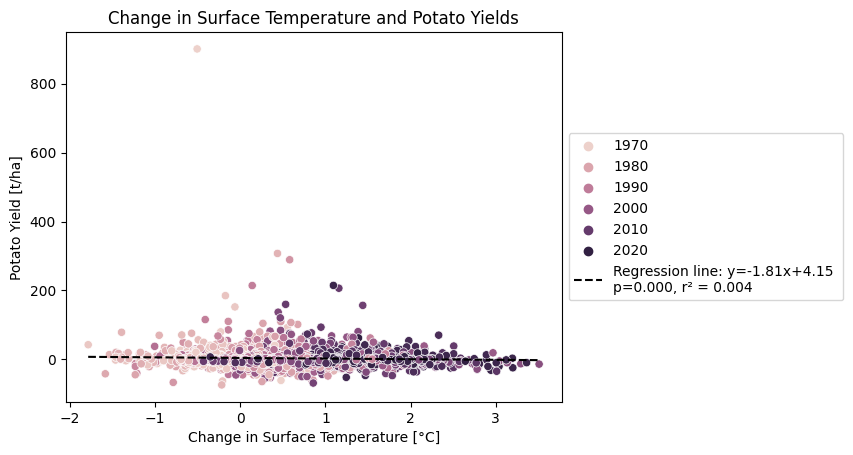

In [56]:
# Normal linear regression (with outliers)
sns.scatterplot(x='Value_T', y='Value_Y', hue='Year', data=df_panel_growth)

x = df_panel_growth.sort_values("Value_T").Value_T
y = df_panel_growth.sort_values("Value_T").Value_Y

ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]

trendline = slope * x + intercept

line = f'Regression line: y={slope:.2f}x+{intercept:.2f} \np={ols_canned_results.pvalues[1]:.3f}, r² = {ols_canned_results.rsquared:.3f}'

plt.plot(x, trendline, '--', color='k', label=line)

plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Potato Yield [t/ha]')
plt.title('Change in Surface Temperature and Potato Yields')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [57]:
#display regression tables with and without outliers
res_1 = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()
res_2 = sm.OLS.from_formula('Value_Y ~ Value_T + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth).fit()

stargazer = Stargazer([res_1, res_2])
stargazer

In [58]:
est_fe_canned = PanelOLS.from_formula("Value_Y ~ 1 + Value_T +Value_GDP + Value_Fert + Value_Prec_Anom + EntityEffects",
                            data=df_panel_growth_no_outliers.set_index(["Area", "Year"]))
result_no_outliers = est_fe_canned.fit(cov_type='clustered', cluster_entity=True)
est_fe_canned = PanelOLS.from_formula("Value_Y ~ 1 + Value_T +Value_GDP + Value_Fert + Value_Prec_Anom + EntityEffects",
                            data=df_panel_growth.set_index(["Area", "Year"]))
result_outliers = est_fe_canned.fit(cov_type='clustered', cluster_entity=True)

results_list = [result_no_outliers, result_outliers]
results_list

[                          PanelOLS Estimation Summary                           
 Dep. Variable:                Value_Y   R-squared:                        0.0050
 Estimator:                   PanelOLS   R-squared (Between):             -0.4494
 No. Observations:                4598   R-squared (Within):               0.0050
 Date:                Fri, Dec 22 2023   R-squared (Overall):              0.0012
 Time:                        13:38:29   Log-likelihood                -1.968e+04
 Cov. Estimator:             Clustered                                           
                                         F-statistic:                      5.6748
 Entities:                          91   P-value                           0.0001
 Avg Obs:                       50.527   Distribution:                  F(4,4503)
 Min Obs:                       38.000                                           
 Max Obs:                       55.000   F-statistic (robust):             6.7085
                

In [59]:
#create temperature threshold for discontinuity regression
threshold = 2.0
df_panel_growth['dummy_temp'] = df_panel_growth['Value_T'] >= threshold
df_panel_growth["dummy_temp"] = df_panel_growth["dummy_temp"].astype(int)

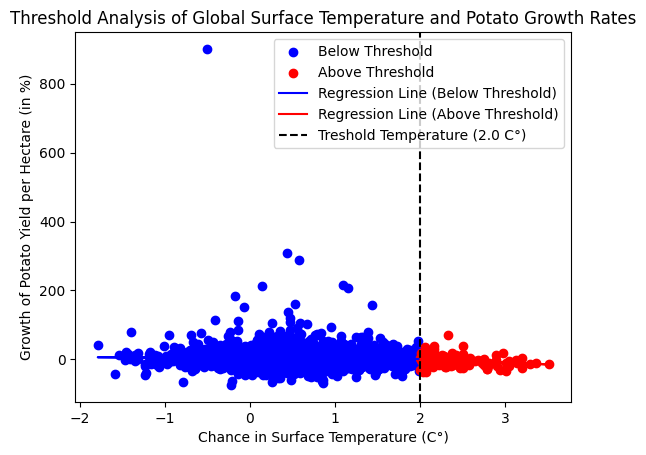

In [60]:
#run regression with threshold
temperature = df_panel_growth['Value_T']
potato_yield = df_panel_growth['Value_Y']

# Create a dummy variable (1 if above threshold, 0 if below threshold)
df_panel_growth['above_threshold'] = (temperature > threshold).astype(int)

# Split the data into two subsets based on the dummy variable
df_below_threshold = df_panel_growth[df_panel_growth['above_threshold'] == 0]
df_above_threshold = df_panel_growth[df_panel_growth['above_threshold'] == 1]

# Fit linear regression models for each subset
model_below_threshold = LinearRegression().fit(df_below_threshold['Value_T'].values.reshape(-1, 1), df_below_threshold['Value_Y'])
model_above_threshold = LinearRegression().fit(df_above_threshold['Value_T'].values.reshape(-1, 1), df_above_threshold['Value_Y'])

# Predict the yields using the fitted models
predictions_below_threshold = model_below_threshold.predict(df_below_threshold['Value_T'].values.reshape(-1, 1))
predictions_above_threshold = model_above_threshold.predict(df_above_threshold['Value_T'].values.reshape(-1, 1))

# Plot the data and regression lines
plt.scatter(df_below_threshold['Value_T'], df_below_threshold['Value_Y'], color='blue', label='Below Threshold')
plt.scatter(df_above_threshold['Value_T'], df_above_threshold['Value_Y'], color='red', label='Above Threshold')

plt.plot(df_below_threshold['Value_T'], predictions_below_threshold, color='blue', label='Regression Line (Below Threshold)')
plt.plot(df_above_threshold['Value_T'], predictions_above_threshold, color='red', label='Regression Line (Above Threshold)')

plt.axvline(x=threshold, color='black', linestyle='--', label='Treshold Temperature (2.0 C°)')

plt.title('Threshold Analysis of Global Surface Temperature and Potato Growth Rates')
plt.xlabel('Chance in Surface Temperature (C°)')
plt.ylabel('Growth of Potato Yield per Hectare (in %)')
plt.legend()
plt.show()

In [61]:
#regression output table for interaction term with temperature threshold both with and without outliers
res_1 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_temp + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()
res_2 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_temp + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth).fit()

stargazer = Stargazer([res_1, res_2])
stargazer

In [62]:
#heterogeneity analysis with outliers
threshold = 0
df_panel_growth['dummy_rain'] = df_panel_growth['Value_Prec_Anom'] >= threshold
df_panel_growth["dummy_rain"] = df_panel_growth["dummy_rain"].astype(int)

,Area,Year,Value_T,Value_Y,Value_GDP,Value_Fert,Value_Prec_Anom,treatment,dummy_temp,above_threshold,dummy_rain
0,Afghanistan,1970,0.703,-6.493506,161.019274,2.42,-3.523269,NaN,0,0,0
1,Afghanistan,1971,0.647,16.745370,164.566181,2.55,-5.013269,NaN,0,0,0
2,Afghanistan,1972,-1.180,-6.634100,146.003034,3.62,3.926731,NaN,0,0,1
3,Afghanistan,1973,0.807,5.822785,147.099044,3.06,-2.337269,NaN,0,0,0
4,Afghanistan,1974,-0.134,-0.328587,173.694213,4.21,-2.563269,NaN,0,0,0


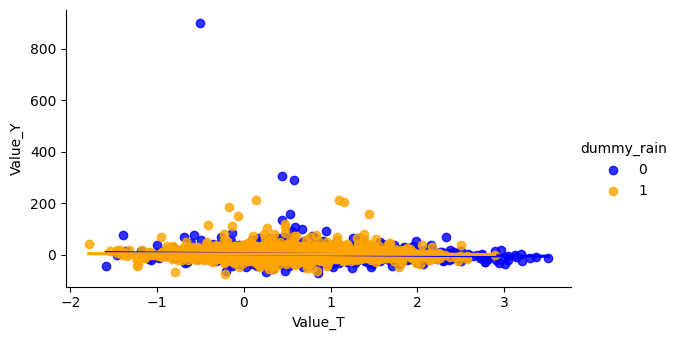

In [63]:
#display the scatter plot with regression line
sns.lmplot(x='Value_T', y='Value_Y', data=df_panel_growth, hue="dummy_rain", height=3.5, aspect=1.7, ci=False)

In [64]:
#regression output table for interaction term with dummy_rain
res_1 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_rain + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()
res_2 = sm.OLS.from_formula('Value_Y ~ Value_T*dummy_rain + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth).fit()

stargazer = Stargazer([res_1, res_2])
stargazer

## 2.6 Cross-Section (for visualization only)

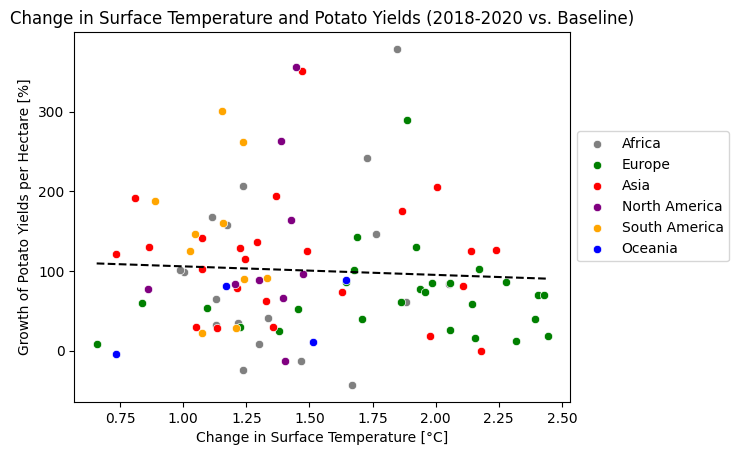

In [65]:
# Linear, cross-section regression without outliers (no controls)

for continent_list, continent_name in [(Africa, 'Africa'), (Europe, 'Europe'), (NA, 'North America'), (SA, 'South America'), (Asia, 'Asia'), (Oceania, 'Oceania')]:
    df_cross.loc[df_cross['Area'].isin(continent_list), 'continent'] = continent_name

continent_colors = {
    "Africa": "grey",
    "Europe": "green",
    "Asia": "red",
    "North America": "purple",
    "South America": "orange",
    "Oceania": "blue",
}

# Scatter plots
for continent, color in continent_colors.items():
    subset = df_cross[df_cross["continent"] == continent]
    sns.scatterplot(x=subset["Value_T"], y=subset["Value_Y"], label=continent, color=color)

# Linear regression
x = df_cross.sort_values("Value_T").Value_T
y = df_cross.sort_values("Value_T").Value_Y

ols_canned_results = sm.OLS.from_formula('Value_Y ~ Value_T', df_cross).fit()
slope = ols_canned_results.params[1]
intercept = ols_canned_results.params[0]

trendline = slope * x + intercept

# Plot regression line without label
plt.plot(x, trendline, '--', color='k', label='_nolegend_')

# Set labels and title
plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Yield Rates [%]')
plt.title('Change in Surface Temperature and Potato Yields (2018-2020 vs. Baseline)')

# Create legend for scatter plots only
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))

# Show the plot
plt.show()

In [67]:
# creating a temperature threshold for the discontinuity regression analysis
threshold = 2
df_cross['dummy_temp'] = df_cross['Value_T'] >= threshold
df_cross["dummy_temp"] = df_cross["dummy_temp"].astype(int)

<Axes: xlabel='Value_T', ylabel='Value_Y'>

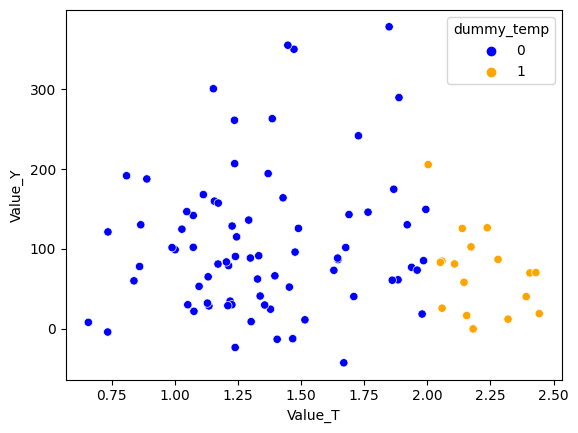

In [68]:
#display scatter
sns.scatterplot(x='Value_T', y='Value_Y', data=df_cross, hue="dummy_temp")

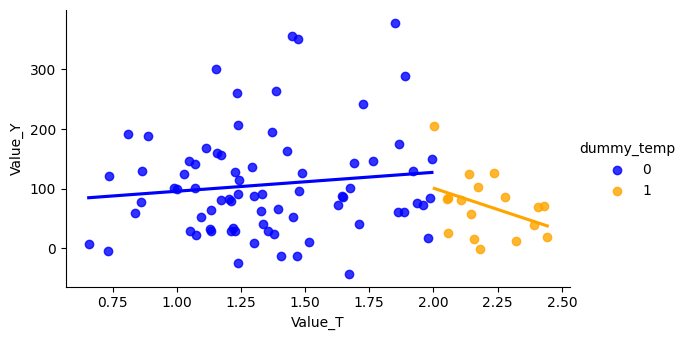

In [69]:
#dispaly simple regression
sns.lmplot(x='Value_T', y='Value_Y', data=df_cross, hue="dummy_temp", height=3.5, aspect=1.7, ci=False)

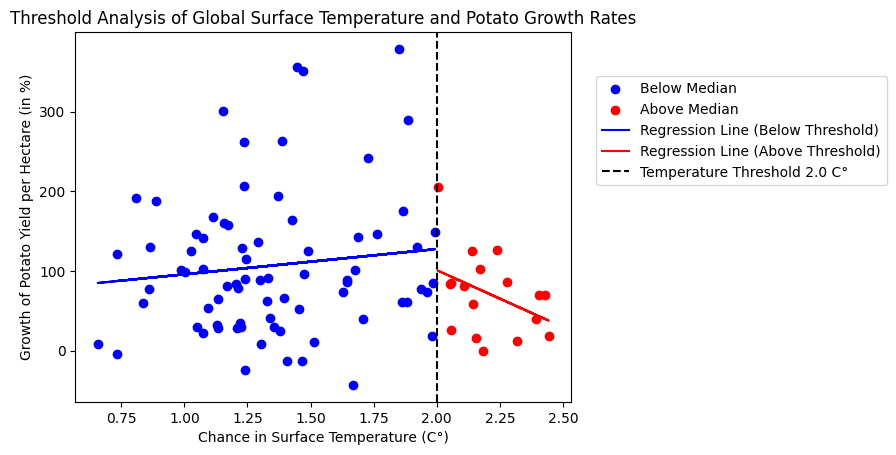

In [70]:
#run linear regression with threshold
temperature = df_cross['Value_T']
potato_yield = df_cross['Value_Y']

# Create a dummy variable (1 if above threshold, 0 if below threshold)
df_cross['above_threshold'] = (temperature > threshold).astype(int)

# Split the data into two subsets based on the dummy variable
df_below_threshold = df_cross[df_cross['above_threshold'] == 0]
df_above_threshold = df_cross[df_cross['above_median'] == 1]

# Fit linear regression models for each subset
model_below_threshold = LinearRegression().fit(df_below_threshold['Value_T'].values.reshape(-1, 1), df_below_threshold['Value_Y'])
model_above_threshold = LinearRegression().fit(df_above_threshold['Value_T'].values.reshape(-1, 1), df_above_threshold['Value_Y'])

# Predict the yields using the fitted models
predictions_below_threshold = model_below_threshold.predict(df_below_threshold['Value_T'].values.reshape(-1, 1))
predictions_above_threshold = model_above_threshold.predict(df_above_threshold['Value_T'].values.reshape(-1, 1))

# Plot the data and regression lines
plt.scatter(df_below_threshold['Value_T'], df_below_threshold['Value_Y'], color='blue', label='Below Median')
plt.scatter(df_above_threshold['Value_T'], df_above_threshold['Value_Y'], color='red', label='Above Median')

plt.plot(df_below_threshold['Value_T'], predictions_below_threshold, color='blue', label='Regression Line (Below Threshold)')
plt.plot(df_above_threshold['Value_T'], predictions_above_threshold, color='red', label='Regression Line (Above Threshold)')

plt.axvline(x=threshold, color='black', linestyle='--', label='Temperature Threshold 2.0 C°')

plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.9))
plt.title('Threshold Analysis of Global Surface Temperature and Potato Growth Rates')
plt.xlabel('Chance in Surface Temperature (C°)')
plt.ylabel('Growth of Potato Yield per Hectare (in %)')
plt.show()

In [71]:
#heterogeneity in cross-section
threshold = 0
df_cross['dummy_rain'] = df_cross['Value_Prec_Anom'] >= threshold
df_cross["dummy_rain"] = df_cross["dummy_rain"].astype(int)
df_cross.head()

,Area,Value_T,Value_Y,continent,dummy_temp,above_median,Value_T_2,Value_Prec_Anom,above_threshold,dummy_rain
0,Afghanistan,1.051000,29.891572,Asia,0,0,1.104601,-0.445936,0,0
1,Albania,1.887667,289.795903,Europe,0,0,3.563285,6.690949,0,1
2,Algeria,1.848667,378.609687,Africa,0,0,3.417568,0.091154,0,1
3,Austria,2.391667,40.042271,Europe,1,1,5.720069,13.879115,1,1
4,Bangladesh,1.244333,115.042753,Asia,0,0,1.548365,-35.900500,0,0


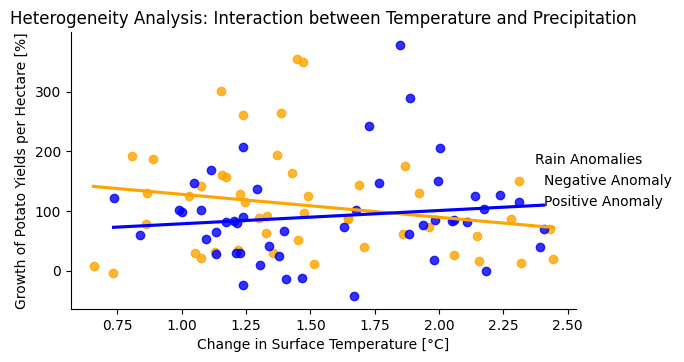

In [72]:
color_palette = {0: 'orange', 1: 'blue'}

# Use the palette parameter in lmplot
scatter_plot = sns.lmplot(x='Value_T', y='Value_Y', data=df_cross, hue="dummy_rain",
                          palette=color_palette, height=3.5, aspect=1.7, ci=False)

# Customize labels and title
scatter_plot.set_axis_labels('Change in Surface Temperature [°C]', 'Growth of Potato Yields per Hectare [%]')
plt.title('Heterogeneity Analysis: Interaction between Temperature and Precipitation')

# Customize legend
scatter_plot._legend.set_title('Rain Anomalies')  # Set the legend title
new_labels = ['Negative Anomaly', 'Positive Anomaly']  # Replace with your actual labels
for t, l in zip(scatter_plot._legend.texts, new_labels): t.set_text(l)

# Show the plot
plt.show()

# Appendix 3: Quadratic Regression (Extra)



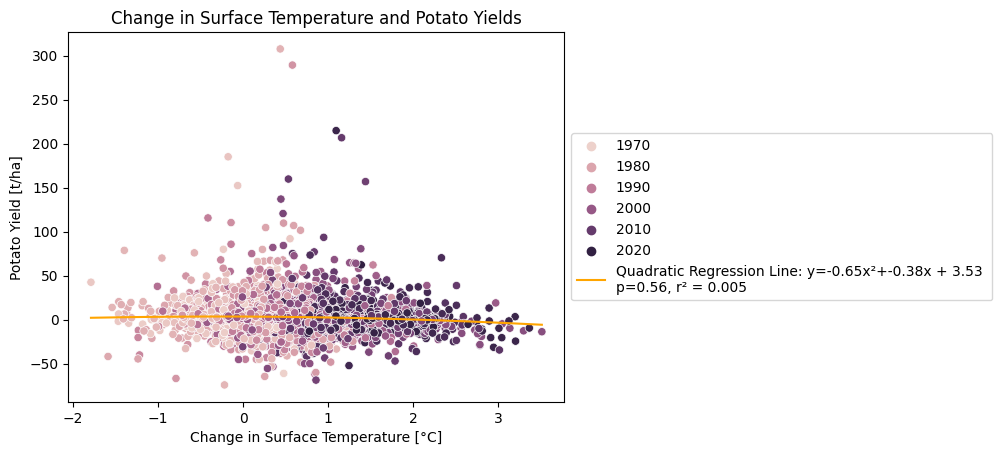

                            OLS Regression Results                            
Dep. Variable:                Value_Y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.774
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           0.000236
Time:                        13:40:09   Log-Likelihood:                -19701.
No. Observations:                4598   AIC:                         3.941e+04
Df Residuals:                    4592   BIC:                         3.945e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5251      0.434     

In [73]:
# Normal quadratic regression
sns.scatterplot(x='Value_T', y='Value_Y', hue="Year", data=df_panel_growth_no_outliers, color="C0")

df_panel_growth_no_outliers['Value_T_2'] = df_panel_growth_no_outliers['Value_T'] * df_panel_growth_no_outliers['Value_T']

model_growth_controls = sm.OLS.from_formula('Value_Y ~ Value_T + Value_T_2 + Value_GDP + Value_Fert + Value_Prec_Anom', df_panel_growth_no_outliers).fit()

x_vals = np.linspace(df_panel_growth_no_outliers['Value_T'].min(), df_panel_growth_no_outliers['Value_T'].max(), 10000)
x_vals_2 = x_vals * x_vals
y_vals = model_growth_controls.params[0] + model_growth_controls.params[1] * x_vals + model_growth_controls.params[2] * x_vals_2

line = f'Quadratic Regression Line: y={model_growth_controls.params[2]:.2f}x²+{model_growth_controls.params[1]:.2f}x + {model_growth_controls.params[0]:.2f} \np={model_growth_controls.pvalues[1]:.2f}, r² = {model_growth_controls.rsquared:.3f}'

plt.plot(x_vals, y_vals, color="C1", label=line)
plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Potato Yield [t/ha]')
plt.title('Change in Surface Temperature and Potato Yields')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print(model_growth_controls.summary())

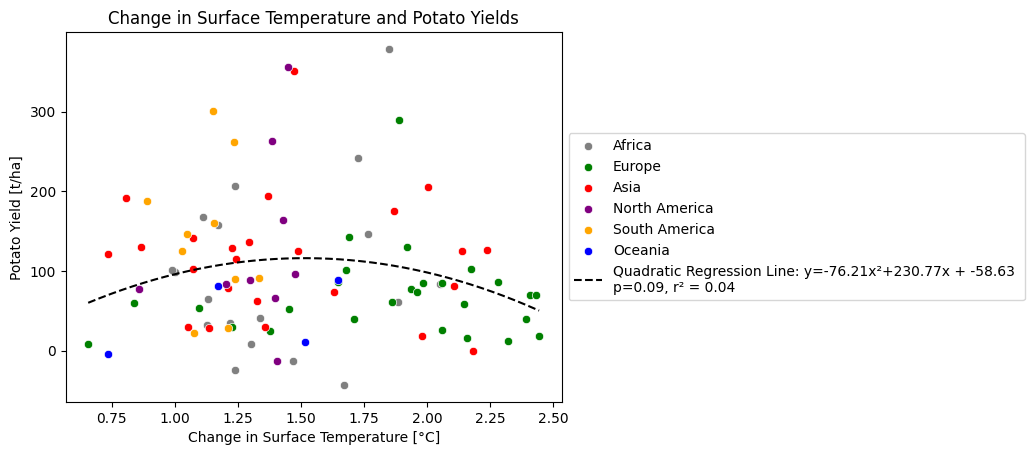

                            OLS Regression Results                            
Dep. Variable:                Value_Y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.782
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.174
Time:                        13:40:18   Log-Likelihood:                -542.52
No. Observations:                  93   AIC:                             1091.
Df Residuals:                      90   BIC:                             1099.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -58.6251    101.692     -0.576      0.5

In [74]:
# Quad, cross-section regression without outliers (no controls)
for continent_list, continent_name in [(Africa, 'Africa'), (Europe, 'Europe'), (NA, 'North America'), (SA, 'South America'), (Asia, 'Asia'), (Oceania, 'Oceania')]:
    df_cross.loc[df_cross['Area'].isin(continent_list), 'continent'] = continent_name

continent_colors = {
    "Africa": "grey",
    "Europe": "green",
    "Asia": "red",
    "North America": "purple",
    "South America": "orange",
    "Oceania": "blue",
}

for continent, color in continent_colors.items():
    subset = df_cross[df_cross["continent"] == continent]
    sns.scatterplot(x=subset["Value_T"], y=subset["Value_Y"], label=continent, color=color)

df_cross['Value_T_2'] = df_cross['Value_T'] * df_cross['Value_T']

model_cross_section = sm.OLS.from_formula('Value_Y ~ Value_T + Value_T_2', df_cross).fit()

x_vals = np.linspace(df_cross['Value_T'].min(), df_cross['Value_T'].max(), 10000)
x_vals_2 = x_vals * x_vals
y_vals = model_cross_section.params[0] + model_cross_section.params[1] * x_vals + model_cross_section.params[2] * x_vals_2

line = f'Quadratic Regression Line: y={model_cross_section.params[2]:.2f}x²+{model_cross_section.params[1]:.2f}x + {model_cross_section.params[0]:.2f} \np={model_cross_section.pvalues[1]:.2f}, r² = {model_cross_section.rsquared:.2f}'

plt.plot(x_vals, y_vals, '--', color="k", label=line)
plt.xlabel('Change in Surface Temperature [°C]')
plt.ylabel('Potato Yield [t/ha]')
plt.title('Change in Surface Temperature and Potato Yields')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print(model_cross_section.summary())